In [1]:
# Display tools
from IPython.display import HTML, display  # For HTML rendering in notebooks
import os 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import os

def get_dicom_paths(directory_path, label=None, verbose=True):
    """
    Scans a directory for DICOM (.dcm) files and returns their paths.

    Parameters:
    - directory_path (str): Directory to scan for .dcm files
    - label (str, optional): Label for display (e.g., 'train', 'test')
    - verbose (bool): Whether to print the number of files found

    Returns:
    - List[str]: Paths to DICOM files
    """
    dicom_paths = [
        os.path.join(directory_path, file)
        for file in os.listdir(directory_path)
        if file.lower().endswith('.dcm')
    ]
    
    if verbose:
        label_text = f" in the '{label}' directory" if label else ""
        print(f" Found {len(dicom_paths)} DICOM files{label_text}.")
    
    return dicom_paths

# --- Define Image Directories ---
TRAIN_IMG_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images"
TEST_IMG_DIR  = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_test_images"

# --- Get File Paths ---
train_img_path = get_dicom_paths(TRAIN_IMG_DIR, label="train")
test_img_path  = get_dicom_paths(TEST_IMG_DIR, label="test")


 Found 26684 DICOM files in the 'train' directory.
 Found 3000 DICOM files in the 'test' directory.


In [39]:
labels = pd.read_csv(r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_labels.csv")
labels.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [4]:
count_normal = len(labels.loc[labels['Target']==0])
count_pnemonia= len(labels.loc[labels['Target']==1])
traing_count=len(train_img_path)

In [5]:
weight_for_zero =(1/count_normal)*(traing_count)/2.0
weight_for_ones =(1/count_pnemonia)*(traing_count)/2.0

In [6]:
classweight= {0: weight_for_zero,
              1: weight_for_ones}

In [7]:
print("Weights:", classweight)

Weights: {0: 0.6454140866873065, 1: 1.3963369963369963}


In [8]:
def parseMetadata(dcm):  # corrected from 'paraseMetadata'
    unpackedData = {}
    groupElemToKeywords = {}
    
    for d in dcm:  # This forces conversion from lazy RawDataElement to DataElement
        pass

    # Un-pack Data
    for tag, elem in dcm.items():
        tagGroup = tag.group
        tagElem = tag.elem
        keyword = elem.keyword
        groupElemToKeywords[(tagGroup, tagElem)] = keyword
        value = elem.value
        unpackedData[keyword] = value
        
    return unpackedData, groupElemToKeywords


In [11]:
import pydicom
from tqdm import tqdm

In [12]:


# Step 1: Read DICOM files from paths
train_dcms = [pydicom.dcmread(path) for path in tqdm(train_img_path[:5000])]
test_dcms = [pydicom.dcmread(path) for path in tqdm(test_img_path[:5000])]




  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [01:16<00:00, 39.38it/s]


In [13]:
# Step 2: Parse metadata from DICOM datasets
trainMetaDicts, trainKeyword = zip(*[parseMetadata(dcm) for dcm in tqdm(train_dcms)])
testMetaDicts, testKeyword = zip(*[parseMetadata(dcm) for dcm in tqdm(test_dcms)])

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:04<00:00, 669.61it/s]


In [14]:
def createY(df):
    """
    Returns binary labels: 1 if 'SeriesDescription' is 'view: PA', else 0.
    """
    if 'SeriesDescription' not in df.columns:
        raise ValueError("Missing 'SeriesDescription' column in DataFrame.")
    
    return (df['SeriesDescription'] == 'view: PA').astype(int).values


In [15]:
train_df = pd.DataFrame.from_dict(data=trainMetaDicts)
test_df = pd.DataFrame.from_dict(data=testMetaDicts)

train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

train_Y = createY(train_df)
test_Y = createY(test_df)


In [16]:
def decodeImage(filePath):
    image = pydicom.dcmread(filePath).pixel_array
    image = cv2.resize(image, (64, 64))
    return image / 255.0


In [17]:

import cv2
import numpy as np

# Get our train x in the correct shape
train_X = []

for filePath in tqdm(train_img_path[:5000]):
    
    img = decodeImage(filePath)
    train_X.append(img)


train_X = np.array(train_X) # Convert to np.array
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 5000/5000 [01:10<00:00, 71.37it/s]


In [18]:
test_X =[]
for filePath in tqdm(test_img_path[:5000]):
    
    img = decodeImage(filePath)
    test_X.append(img)

test_X = np.array(test_X) # Convert to np array
test_X_rgb = np.repeat(test_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 3000/3000 [00:43<00:00, 68.99it/s]


In [22]:
import tensorflow as tf

In [21]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model


In [19]:
import matplotlib.pyplot as plt

def plot_score(hist):
    fig, ax = plt.subplots(5, 1, figsize=(10, 20))  # Corrected 'subplot' to 'subplots'
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'precision', 'recall', 'AUC', 'loss']):
        ax[i].plot(hist.history[met])
        ax[i].plot(hist.history['val_' + met])
        ax[i].set_title(f'Model {met}')
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()


In [23]:
# These our our scoring metrics that are going to be used to evaluate our models
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='AUC')]

In [24]:
import tensorflow as tf

# Clear, Flexible Exponential Decay Function
def exponential_decay(lr_initial, decay_steps, decay_rate=0.1):
    """
    Returns a function that computes exponentially decaying learning rate.
    
    Parameters:
    - lr_initial: Initial learning rate
    - decay_steps: Controls the rate of decay
    - decay_rate: The base of the exponential decay (default: 0.1)

    Returns:
    - A function that takes an epoch index and returns the decayed learning rate
    """
    def schedule(epoch):
        return lr_initial * decay_rate ** (epoch / decay_steps)
    return schedule

# Define the scheduler function
exponential_decay_fn = exponential_decay(lr_initial=0.01, decay_steps=20)

# Learning Rate Scheduler Callback
lr_scheduler_cb = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn, verbose=1)

# Model Checkpoint Callback (saves best model only)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="xray_model.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# Early Stopping Callback (restores best weights after patience period)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)


In [25]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw

# Parameters
image_size = (64, 64)  # Target mask size
csv_path = 'la.csv'  # Path to your CSV file

# Load bounding box annotations
df = labels.copy()

# Filter rows with pneumonia (Target == 1)
df = df[df['Target'] == 1]

# Group bounding boxes by patient ID
grouped = df.groupby('patientId')

# Dictionary to store masks
masks = {}

# Generate binary masks
for patient_id, rows in grouped:
    mask = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(mask)

    for _, row in rows.iterrows():
        x, y, w, h = row['x'], row['y'], row['width'], row['height']
        scale_x = image_size[0] / 1024
        scale_y = image_size[1] / 1024
        x1 = int(x * scale_x)
        y1 = int(y * scale_y)
        x2 = int((x + w) * scale_x)
        y2 = int((y + h) * scale_y)
        draw.rectangle([x1, y1, x2, y2], fill=1)

    masks[patient_id] = np.array(mask)


In [35]:
import os
import numpy as np
import pandas as pd
import pydicom
import cv2

# --- Configuration ---
TRAIN_IMG_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images"
CSV_PATH = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_labels.csv"
OUTPUT_DIR = "npy_images"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Load CSV and filter for annotated images (Target == 1) ---
#df = pd.read_csv(CSV_PATH)
annotated_ids = df[df['Target'] == 1]['patientId'].unique()

# --- Convert DICOM to 64x64 RGB .npy ---
def convert_dicom_to_npy(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    img = ds.pixel_array.astype(np.float32)
    img -= np.min(img)
    img /= np.max(img)
    img *= 255.0
    img = img.astype(np.uint8)
    img_resized = cv2.resize(img, (64, 64))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
    return img_rgb

# --- Process and save ---
for patient_id in annotated_ids:
    dicom_file = os.path.join(TRAIN_IMG_DIR, f"{patient_id}.dcm")
    if os.path.exists(dicom_file):
        try:
            img_rgb = convert_dicom_to_npy(dicom_file)
            np.save(os.path.join(OUTPUT_DIR, f"{patient_id}.npy"), img_rgb)
        except Exception as e:
            print(f"Failed to process {patient_id}: {e}")

print("Annotated DICOM images converted to 64x64 RGB .npy files.")


Annotated DICOM images converted to 64x64 RGB .npy files.


In [39]:
from tensorflow.keras import layers, models, Input

def build_unet(input_shape=(128, 128, 1)):
    inputs = Input(input_shape)

    # --- Encoder ---
    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    def encoder_block(x, filters):
        f = conv_block(x, filters)
        p = layers.MaxPooling2D(pool_size=(2, 2))(f)
        return f, p

    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, kernel_size=2, strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip])
        return conv_block(x, filters)

    # Downsampling path
    f1, p1 = encoder_block(inputs, 32)
    f2, p2 = encoder_block(p1, 64)
    f3, p3 = encoder_block(p2, 128)

    # Bottleneck
    b = conv_block(p3, 256)

    # Upsampling path
    d1 = decoder_block(b, f3, 128)
    d2 = decoder_block(d1, f2, 64)
    d3 = decoder_block(d2, f1, 32)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d3)

    model = models.Model(inputs, outputs, name='UNet')
    return model


In [36]:
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# --- Configuration ---
IMAGE_DIR = "npy_images"
IMG_SIZE = (64, 64)
BATCH_SIZE = 256
EPOCHS = 30

# --- Select top 5,000 images ---
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.npy')])[:5000]

# --- Load images and masks ---
images, masks_list = [], []
for fname in image_files:
    patient_id = os.path.splitext(fname)[0]
    if patient_id in masks:
        img_path = os.path.join(IMAGE_DIR, fname)
        img = np.load(img_path)
        mask = masks[patient_id]
        images.append(img)
        masks_list.append(mask)

# Convert to numpy arrays
X = np.array(images) / 255.0  # Normalize images
y = np.expand_dims(np.array(masks_list).astype(np.float32), axis=-1)  # Add channel dimension

# --- Split data ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Define U-Net Model ---
def build_unet(input_shape):
    inputs = Input(input_shape)

    def conv_block(x, filters):
        x = layers.UpSampling2D()(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    def encoder_block(x, filters):
        f = conv_block(x, filters)
        p = layers.MaxPooling2D()(f)
        return f, p

    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        x = layers.concatenate([x, skip])
        return conv_block(x, filters)

    # Drop f4, p4, and one decoder step
    f1, p1 = encoder_block(inputs, 32)
    f2, p2 = encoder_block(p1, 64)
    f3, p3 = encoder_block(p2, 128)

    bottleneck = conv_block(p3, 256)

    d1 = decoder_block(bottleneck, f3, 128)
    d2 = decoder_block(d1, f2, 64)
    d3 = decoder_block(d2, f1, 32)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d3)


    return models.Model(inputs, outputs)

# Build and compile the U-Net model
model = build_unet((IMG_SIZE[0], IMG_SIZE[1], 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 256, 256, 128), (None, 128, 128, 128)]

In [40]:
# --- Compile and Train ---
model = build_unet((64, 64, 3))
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=METRICS)
history_unet=model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS,callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_cb])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - AUC: 0.4632 - accuracy: 0.8554 - loss: 3.9772 - precision: 0.0019 - recall: 1.4398e-04
Epoch 1: val_loss improved from inf to 0.45635, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 151s 9s/step - AUC: 0.4628 - accuracy: 0.8557 - loss: 3.9072 - precision: 0.0019 - recall: 1.3802e-04 - val_AUC: 0.2747 - val_accuracy: 0.8624 - val_loss: 0.4564 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.008912509381337455.
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - AUC: 0.3295 - accuracy: 0.8655 - loss: 0.4464 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_loss improved from 0.45635 to 0.42339, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 163s 10s/step - AUC: 0.3295 - accuracy: 0.8654 - loss: 0.4461 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.3768 - val_accuracy: 0.8624 - val_loss: 0.4234 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0089

Epoch 3: LearningRateScheduler setting learning rate to 0.007943282347242816.
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - AUC: 0.5087 - accuracy: 0.8649 - loss: 0.4043 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3: val_loss did not improve from 0.42339
16/16 ━━━━━━━━━━━━━━━━━━━━ 136s 8s/step - AUC: 0.5115 - accuracy: 0.8649 - loss: 0.4045 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.7282 - val_accuracy: 0.8624 - val_loss: 0.4407 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0079

Epoch 4: LearningRateScheduler setting learning rate to 0.0070794578438413795.
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - AUC: 0.6503 - accuracy: 0.8636 - loss: 0.3960 - precision: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 104s 6s/step - AUC: 0.6517 - accuracy: 0.8636 - loss: 0.3947 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.7714 - val_accuracy: 0.8624 - val_loss: 0.3528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0071

Epoch 5: LearningRateScheduler setting learning rate to 0.006309573444801933.
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - AUC: 0.7666 - accuracy: 0.8647 - loss: 0.3353 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5: val_loss improved from 0.35282 to 0.31714, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 125s 8s/step - AUC: 0.7675 - accuracy: 0.8647 - loss: 0.3349 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.8222 - val_accuracy: 0.8624 - val_loss: 0.3171 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0063

Epoch 6: LearningRateScheduler setting learning rate to 0.005623413251903491.
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - AUC: 0.8224 - accuracy: 0.8616 - loss: 0.3166 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6: val_loss did not improve from 0.31714
16/16 ━━━━━━━━━━━━━━━━━━━━ 132s 8s/step - AUC: 0.8223 - accuracy: 0.8617 - loss: 0.3163 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.8250 - val_accuracy: 0.8624 - val_loss: 0.3209 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0056

Epoch 7: LearningRateScheduler setting learning rate to 0.005011872336272724.
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - AUC: 0.8221 - accuracy: 0.8644 - loss: 0.3156 - precision: 0.0

16/16 ━━━━━━━━━━━━━━━━━━━━ 107s 7s/step - AUC: 0.8221 - accuracy: 0.8644 - loss: 0.3155 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.8312 - val_accuracy: 0.8624 - val_loss: 0.3092 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0050

Epoch 8: LearningRateScheduler setting learning rate to 0.004466835921509631.
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - AUC: 0.8276 - accuracy: 0.8642 - loss: 0.3084 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 8: val_loss improved from 0.30918 to 0.30701, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 216s 14s/step - AUC: 0.8277 - accuracy: 0.8642 - loss: 0.3083 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.8354 - val_accuracy: 0.8624 - val_loss: 0.3070 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0045

Epoch 9: LearningRateScheduler setting learning rate to 0.0039810717055349725.
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - AUC: 0.8330 - accuracy: 0.8654 - loss: 0.3042 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 9: val_loss improved from 0.30701 to 0.30559, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 238s 15s/step - AUC: 0.8330 - accuracy: 0.8653 - loss: 0.3043 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.8399 - val_accuracy: 0.8624 - val_loss: 0.3056 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0040

Epoch 10: LearningRateScheduler setting learning rate to 0.003548133892335755.
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - AUC: 0.8366 - accuracy: 0.8669 - loss: 0.3006 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 10: val_loss improved from 0.30559 to 0.30429, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 209s 11s/step - AUC: 0.8366 - accuracy: 0.8668 - loss: 0.3008 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.8421 - val_accuracy: 0.8624 - val_loss: 0.3043 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0035

Epoch 11: LearningRateScheduler setting learning rate to 0.0031622776601683794.
Epoch 11/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - AUC: 0.8423 - accuracy: 0.8640 - loss: 0.3012 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 11: val_loss did not improve from 0.30429
16/16 ━━━━━━━━━━━━━━━━━━━━ 173s 11s/step - AUC: 0.8421 - accuracy: 0.8640 - loss: 0.3013 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.8422 - val_accuracy: 0.8624 - val_loss: 0.3075 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0032

Epoch 12: LearningRateScheduler setting learning rate to 0.002818382931264454.
Epoch 12/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - AUC: 0.8348 - accuracy: 0.8625 - loss: 0.3082 - pre

16/16 ━━━━━━━━━━━━━━━━━━━━ 198s 13s/step - AUC: 0.8349 - accuracy: 0.8625 - loss: 0.3080 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.8438 - val_accuracy: 0.8624 - val_loss: 0.3018 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0028

Epoch 13: LearningRateScheduler setting learning rate to 0.0025118864315095803.
Epoch 13/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - AUC: 0.8416 - accuracy: 0.8645 - loss: 0.3004 - precision: 0.3517 - recall: 0.0377 
Epoch 13: val_loss improved from 0.30183 to 0.30059, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 217s 14s/step - AUC: 0.8416 - accuracy: 0.8644 - loss: 0.3004 - precision: 0.3606 - recall: 0.0404 - val_AUC: 0.8447 - val_accuracy: 0.8637 - val_loss: 0.3006 - val_precision: 0.5319 - val_recall: 0.0784 - learning_rate: 0.0025

Epoch 14: LearningRateScheduler setting learning rate to 0.0022387211385683395.
Epoch 14/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - AUC: 0.8416 - accuracy: 0.8669 - loss: 0.2968 - precision: 0.5031 - recall: 0.0673 
Epoch 14: val_loss did not improve from 0.30059
16/16 ━━━━━━━━━━━━━━━━━━━━ 274s 17s/step - AUC: 0.8416 - accuracy: 0.8668 - loss: 0.2970 - precision: 0.5031 - recall: 0.0684 - val_AUC: 0.8442 - val_accuracy: 0.8624 - val_loss: 0.3071 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0022

Epoch 15: LearningRateScheduler setting learning rate to 0.0019952623149688802.
Epoch 15/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - AUC: 0.8412 - accuracy: 0.8645 - loss: 0.3014 - precision: 0.4564 - recall: 0.0430

16/16 ━━━━━━━━━━━━━━━━━━━━ 221s 11s/step - AUC: 0.8413 - accuracy: 0.8645 - loss: 0.3013 - precision: 0.4597 - recall: 0.0454 - val_AUC: 0.8460 - val_accuracy: 0.8624 - val_loss: 0.3005 - val_precision: 0.4889 - val_recall: 0.0066 - learning_rate: 0.0020

Epoch 16: LearningRateScheduler setting learning rate to 0.001778279410038923.
Epoch 16/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - AUC: 0.8438 - accuracy: 0.8621 - loss: 0.3024 - precision: 0.5149 - recall: 0.0909 
Epoch 16: val_loss improved from 0.30047 to 0.29601, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 184s 12s/step - AUC: 0.8439 - accuracy: 0.8623 - loss: 0.3021 - precision: 0.5151 - recall: 0.0933 - val_AUC: 0.8504 - val_accuracy: 0.8651 - val_loss: 0.2960 - val_precision: 0.5398 - val_recall: 0.1305 - learning_rate: 0.0018

Epoch 17: LearningRateScheduler setting learning rate to 0.0015848931924611134.
Epoch 17/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - AUC: 0.8491 - accuracy: 0.8651 - loss: 0.2947 - precision: 0.5238 - recall: 0.0861 
Epoch 17: val_loss improved from 0.29601 to 0.29299, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 185s 12s/step - AUC: 0.8492 - accuracy: 0.8651 - loss: 0.2947 - precision: 0.5239 - recall: 0.0865 - val_AUC: 0.8545 - val_accuracy: 0.8660 - val_loss: 0.2930 - val_precision: 0.5411 - val_recall: 0.1727 - learning_rate: 0.0016

Epoch 18: LearningRateScheduler setting learning rate to 0.0014125375446227546.
Epoch 18/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - AUC: 0.8531 - accuracy: 0.8654 - loss: 0.2939 - precision: 0.5373 - recall: 0.1609
Epoch 18: val_loss improved from 0.29299 to 0.29063, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 148s 9s/step - AUC: 0.8531 - accuracy: 0.8654 - loss: 0.2938 - precision: 0.5370 - recall: 0.1604 - val_AUC: 0.8575 - val_accuracy: 0.8667 - val_loss: 0.2906 - val_precision: 0.5555 - val_recall: 0.1562 - learning_rate: 0.0014

Epoch 19: LearningRateScheduler setting learning rate to 0.0012589254117941673.
Epoch 19/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - AUC: 0.8540 - accuracy: 0.8669 - loss: 0.2904 - precision: 0.5252 - recall: 0.1623
Epoch 19: val_loss improved from 0.29063 to 0.28872, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 155s 10s/step - AUC: 0.8540 - accuracy: 0.8669 - loss: 0.2905 - precision: 0.5255 - recall: 0.1622 - val_AUC: 0.8603 - val_accuracy: 0.8680 - val_loss: 0.2887 - val_precision: 0.5482 - val_recall: 0.2287 - learning_rate: 0.0013

Epoch 20: LearningRateScheduler setting learning rate to 0.0011220184543019637.
Epoch 20/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - AUC: 0.8580 - accuracy: 0.8686 - loss: 0.2869 - precision: 0.5335 - recall: 0.2018 
Epoch 20: val_loss improved from 0.28872 to 0.28656, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 177s 11s/step - AUC: 0.8581 - accuracy: 0.8685 - loss: 0.2870 - precision: 0.5338 - recall: 0.2017 - val_AUC: 0.8633 - val_accuracy: 0.8696 - val_loss: 0.2866 - val_precision: 0.5579 - val_recall: 0.2516 - learning_rate: 0.0011

Epoch 21: LearningRateScheduler setting learning rate to 0.001.
Epoch 21/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - AUC: 0.8630 - accuracy: 0.8703 - loss: 0.2848 - precision: 0.5522 - recall: 0.2453 
Epoch 21: val_loss improved from 0.28656 to 0.27974, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 244s 14s/step - AUC: 0.8631 - accuracy: 0.8703 - loss: 0.2847 - precision: 0.5526 - recall: 0.2459 - val_AUC: 0.8712 - val_accuracy: 0.8755 - val_loss: 0.2797 - val_precision: 0.5860 - val_recall: 0.3232 - learning_rate: 0.0010

Epoch 22: LearningRateScheduler setting learning rate to 0.0008912509381337455.
Epoch 22/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - AUC: 0.8693 - accuracy: 0.8752 - loss: 0.2786 - precision: 0.5723 - recall: 0.3037
Epoch 22: val_loss improved from 0.27974 to 0.27622, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 153s 10s/step - AUC: 0.8694 - accuracy: 0.8752 - loss: 0.2786 - precision: 0.5722 - recall: 0.3044 - val_AUC: 0.8771 - val_accuracy: 0.8758 - val_loss: 0.2762 - val_precision: 0.5695 - val_recall: 0.3981 - learning_rate: 8.9125e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0007943282347242814.
Epoch 23/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - AUC: 0.8755 - accuracy: 0.8749 - loss: 0.2772 - precision: 0.5758 - recall: 0.3555
Epoch 23: val_loss improved from 0.27622 to 0.27190, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 168s 11s/step - AUC: 0.8756 - accuracy: 0.8750 - loss: 0.2770 - precision: 0.5761 - recall: 0.3551 - val_AUC: 0.8812 - val_accuracy: 0.8791 - val_loss: 0.2719 - val_precision: 0.6186 - val_recall: 0.3152 - learning_rate: 7.9433e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0007079457843841381.
Epoch 24/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - AUC: 0.8792 - accuracy: 0.8783 - loss: 0.2707 - precision: 0.5793 - recall: 0.3627 
Epoch 24: val_loss improved from 0.27190 to 0.26927, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 255s 14s/step - AUC: 0.8793 - accuracy: 0.8783 - loss: 0.2707 - precision: 0.5795 - recall: 0.3635 - val_AUC: 0.8843 - val_accuracy: 0.8807 - val_loss: 0.2693 - val_precision: 0.6283 - val_recall: 0.3257 - learning_rate: 7.0795e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0006309573444801933.
Epoch 25/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - AUC: 0.8824 - accuracy: 0.8800 - loss: 0.2685 - precision: 0.5963 - recall: 0.3561 
Epoch 25: val_loss improved from 0.26927 to 0.26626, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 213s 11s/step - AUC: 0.8824 - accuracy: 0.8800 - loss: 0.2685 - precision: 0.5962 - recall: 0.3566 - val_AUC: 0.8869 - val_accuracy: 0.8819 - val_loss: 0.2663 - val_precision: 0.6078 - val_recall: 0.3979 - learning_rate: 6.3096e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0005623413251903491.
Epoch 26/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - AUC: 0.8842 - accuracy: 0.8806 - loss: 0.2667 - precision: 0.5913 - recall: 0.3822
Epoch 26: val_loss improved from 0.26626 to 0.26534, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 183s 10s/step - AUC: 0.8843 - accuracy: 0.8806 - loss: 0.2667 - precision: 0.5917 - recall: 0.3816 - val_AUC: 0.8884 - val_accuracy: 0.8818 - val_loss: 0.2653 - val_precision: 0.5992 - val_recall: 0.4245 - learning_rate: 5.6234e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0005011872336272723.
Epoch 27/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - AUC: 0.8860 - accuracy: 0.8802 - loss: 0.2659 - precision: 0.5917 - recall: 0.3867 
Epoch 27: val_loss improved from 0.26534 to 0.26313, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 195s 12s/step - AUC: 0.8861 - accuracy: 0.8802 - loss: 0.2658 - precision: 0.5923 - recall: 0.3863 - val_AUC: 0.8901 - val_accuracy: 0.8839 - val_loss: 0.2631 - val_precision: 0.6272 - val_recall: 0.3852 - learning_rate: 5.0119e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.00044668359215096305.
Epoch 28/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - AUC: 0.8897 - accuracy: 0.8825 - loss: 0.2626 - precision: 0.6062 - recall: 0.3960
Epoch 28: val_loss improved from 0.26313 to 0.26140, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 140s 9s/step - AUC: 0.8897 - accuracy: 0.8825 - loss: 0.2626 - precision: 0.6066 - recall: 0.3953 - val_AUC: 0.8923 - val_accuracy: 0.8848 - val_loss: 0.2614 - val_precision: 0.6195 - val_recall: 0.4222 - learning_rate: 4.4668e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.00039810717055349735.
Epoch 29/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - AUC: 0.8912 - accuracy: 0.8842 - loss: 0.2615 - precision: 0.6115 - recall: 0.4175 
Epoch 29: val_loss improved from 0.26140 to 0.25927, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 160s 10s/step - AUC: 0.8912 - accuracy: 0.8842 - loss: 0.2614 - precision: 0.6116 - recall: 0.4168 - val_AUC: 0.8940 - val_accuracy: 0.8854 - val_loss: 0.2593 - val_precision: 0.6236 - val_recall: 0.4219 - learning_rate: 3.9811e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.00035481338923357554.
Epoch 30/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - AUC: 0.8933 - accuracy: 0.8851 - loss: 0.2584 - precision: 0.6183 - recall: 0.4011 
Epoch 30: val_loss improved from 0.25927 to 0.25779, saving model to xray_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 173s 11s/step - AUC: 0.8933 - accuracy: 0.8851 - loss: 0.2584 - precision: 0.6187 - recall: 0.4007 - val_AUC: 0.8955 - val_accuracy: 0.8864 - val_loss: 0.2578 - val_precision: 0.6215 - val_recall: 0.4451 - learning_rate: 3.5481e-04
Restoring model weights from the end of the best epoch: 30.


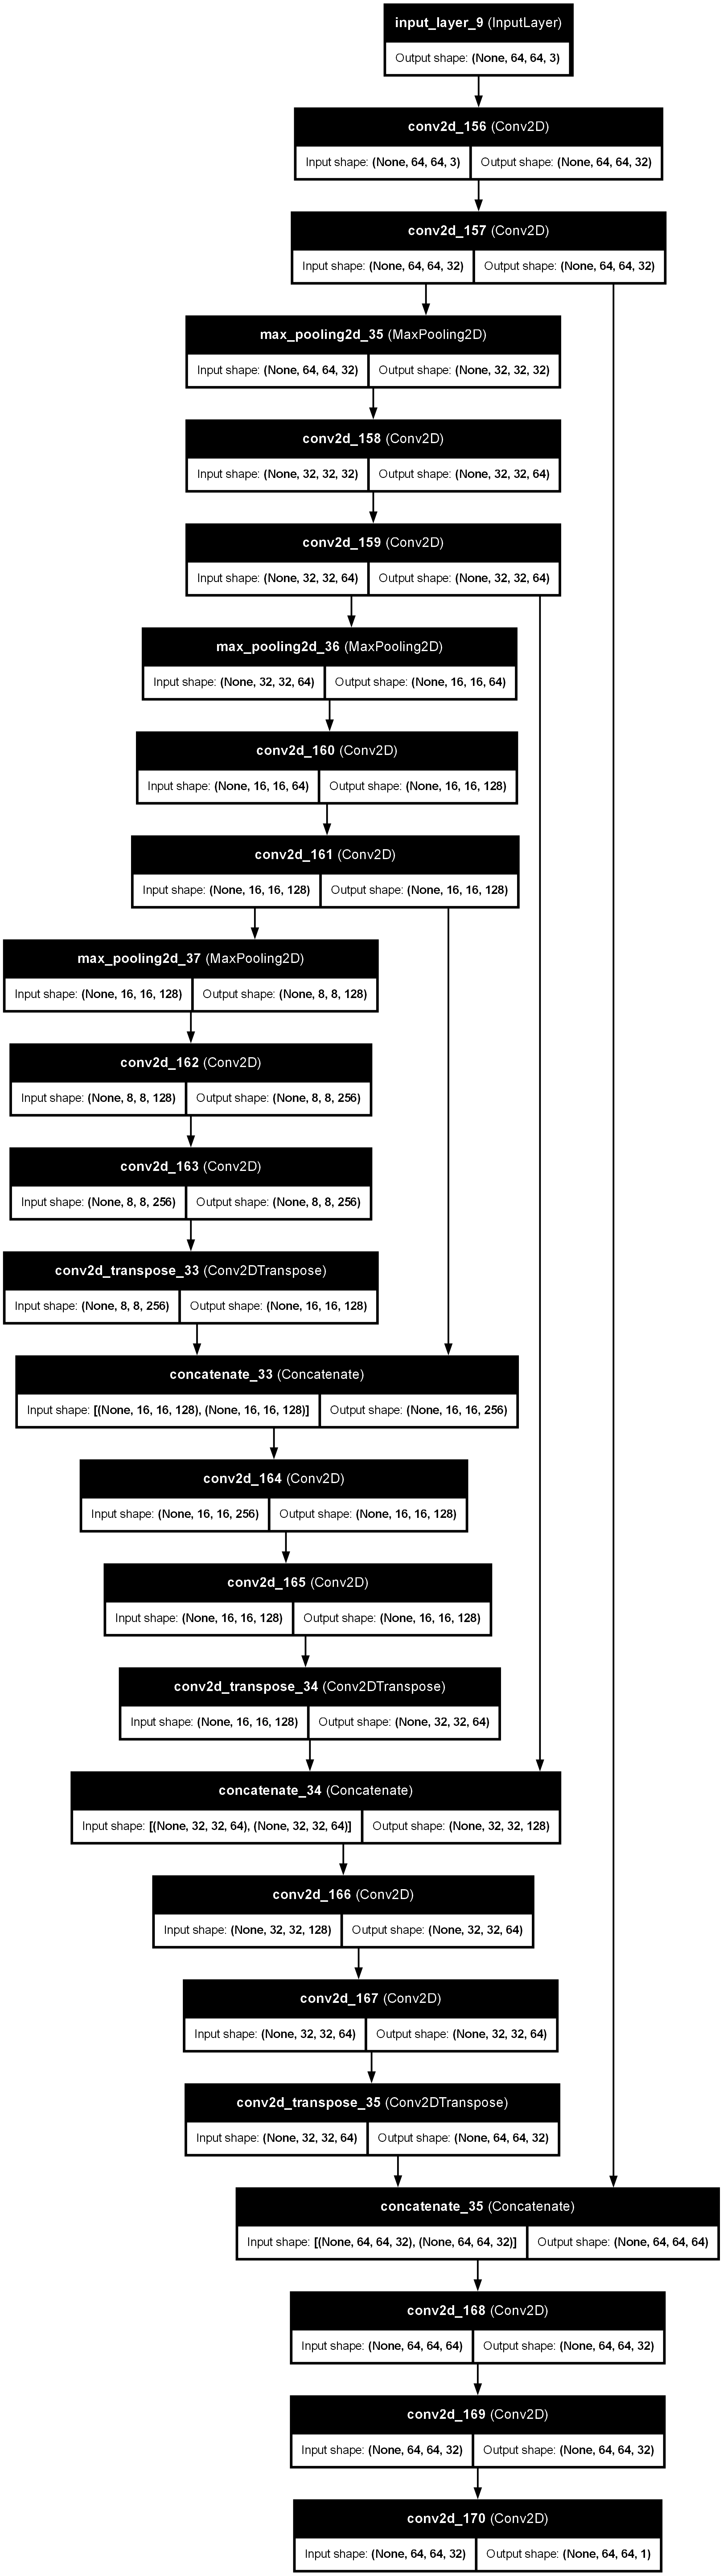

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file="unet_model.png")


Using DICOM file: C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images\ac1f5622-570b-4f7b-b977-213933d2b06b.dcm


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


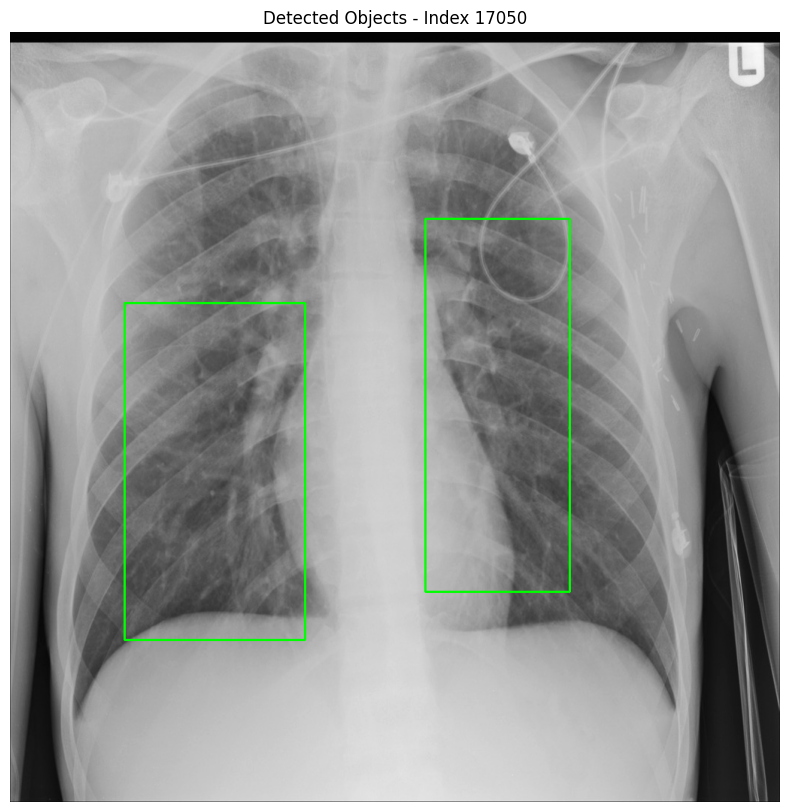

In [16]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
from tensorflow.keras.models import load_model

# --- Define DICOM path loader ---
def get_dicom_paths(directory):
    return [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith(".dcm")]

# --- Directories ---
TRAIN_IMG_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images"
train_img_path = get_dicom_paths(TRAIN_IMG_DIR)

# --- Load U-Net model ---
model = load_model(r'C:\Users\samya\PyCharmProject\Pneumonia-Detection\xray_model.h5')  # Replace with your actual model path

# --- Select a random image beyond the first 5000 ---
random_index = random.choice(range(5000, len(train_img_path)))
dicom_path = train_img_path[random_index]
print(f"Using DICOM file: {dicom_path}")

# --- Load and preprocess DICOM image ---
dicom = pydicom.dcmread(dicom_path)
image = dicom.pixel_array.astype(np.float32)
image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
original_size = image.shape

# Resize to model input size and convert to 3 channels
input_image = cv2.resize(image, (64, 64))
input_image = cv2.cvtColor(input_image, cv2.COLOR_GRAY2RGB)
input_image = input_image / 255.0
input_image = np.expand_dims(input_image, axis=0)  # Shape: (1, 64, 64, 3)

# --- Predict segmentation mask ---
predicted_mask = model.predict(input_image)[0, :, :, 0]
binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255
binary_mask_resized = cv2.resize(binary_mask, (original_size[1], original_size[0]))

# --- Find contours and draw bounding boxes ---
contours, _ = cv2.findContours(binary_mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# --- Display result ---
plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.title(f"Detected Objects - Index {random_index}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


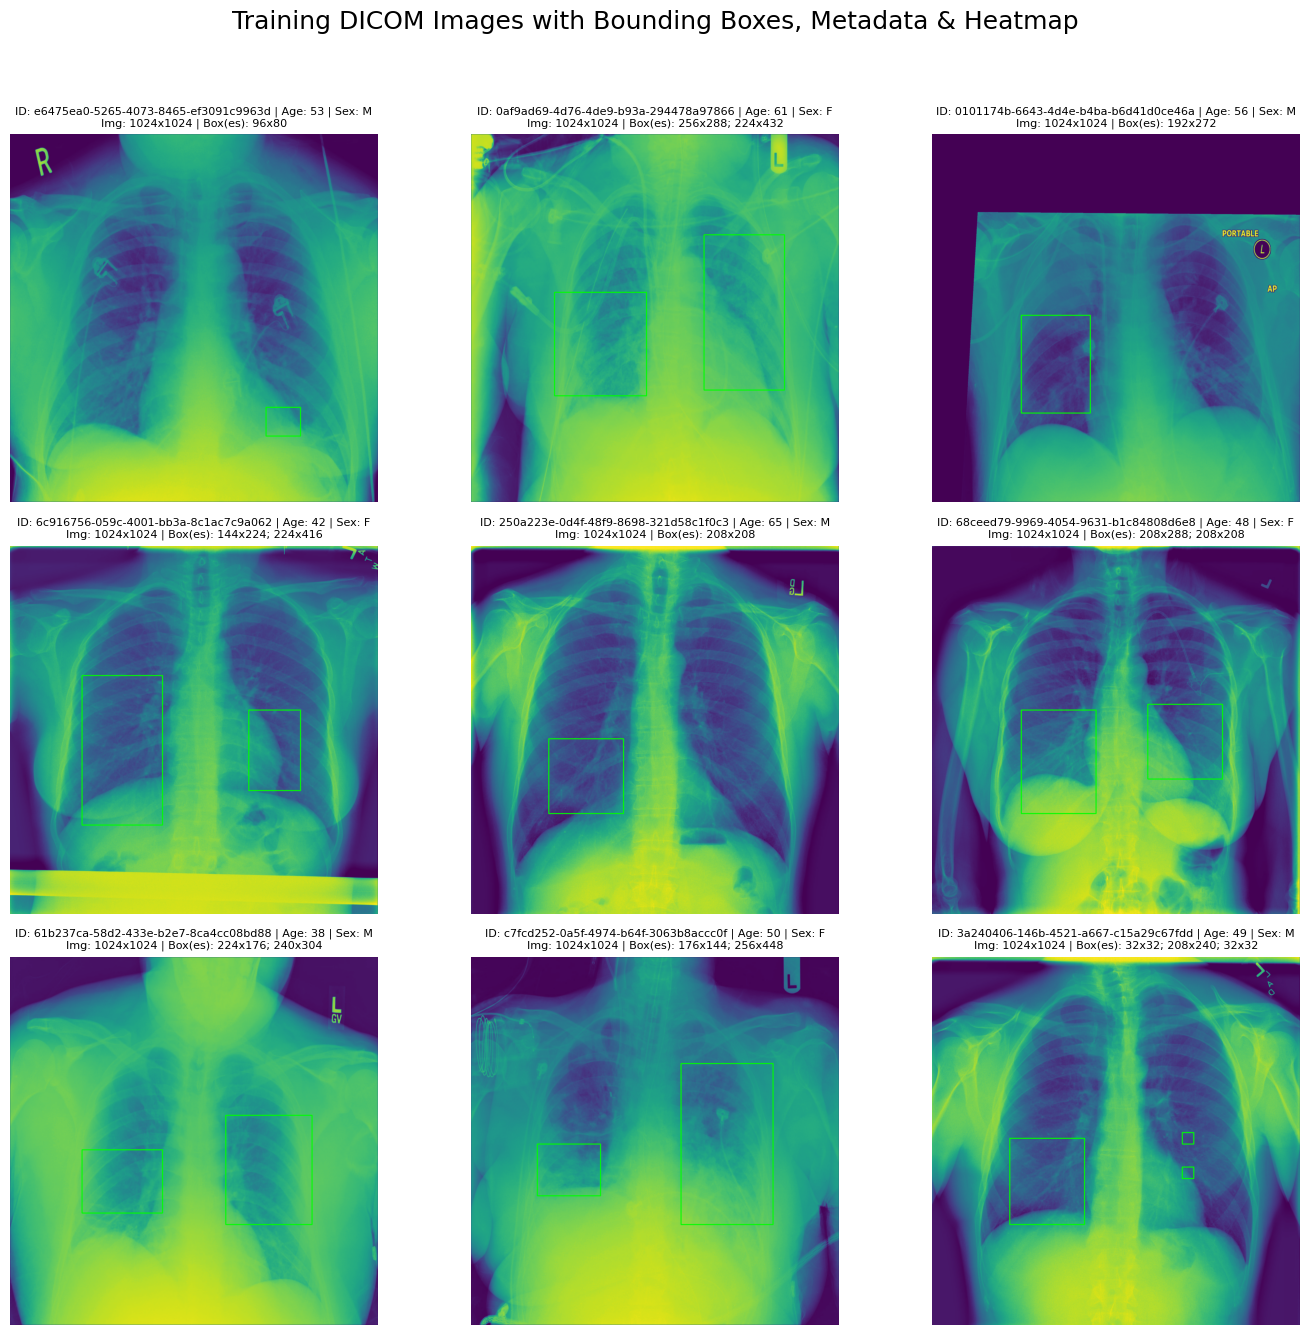

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


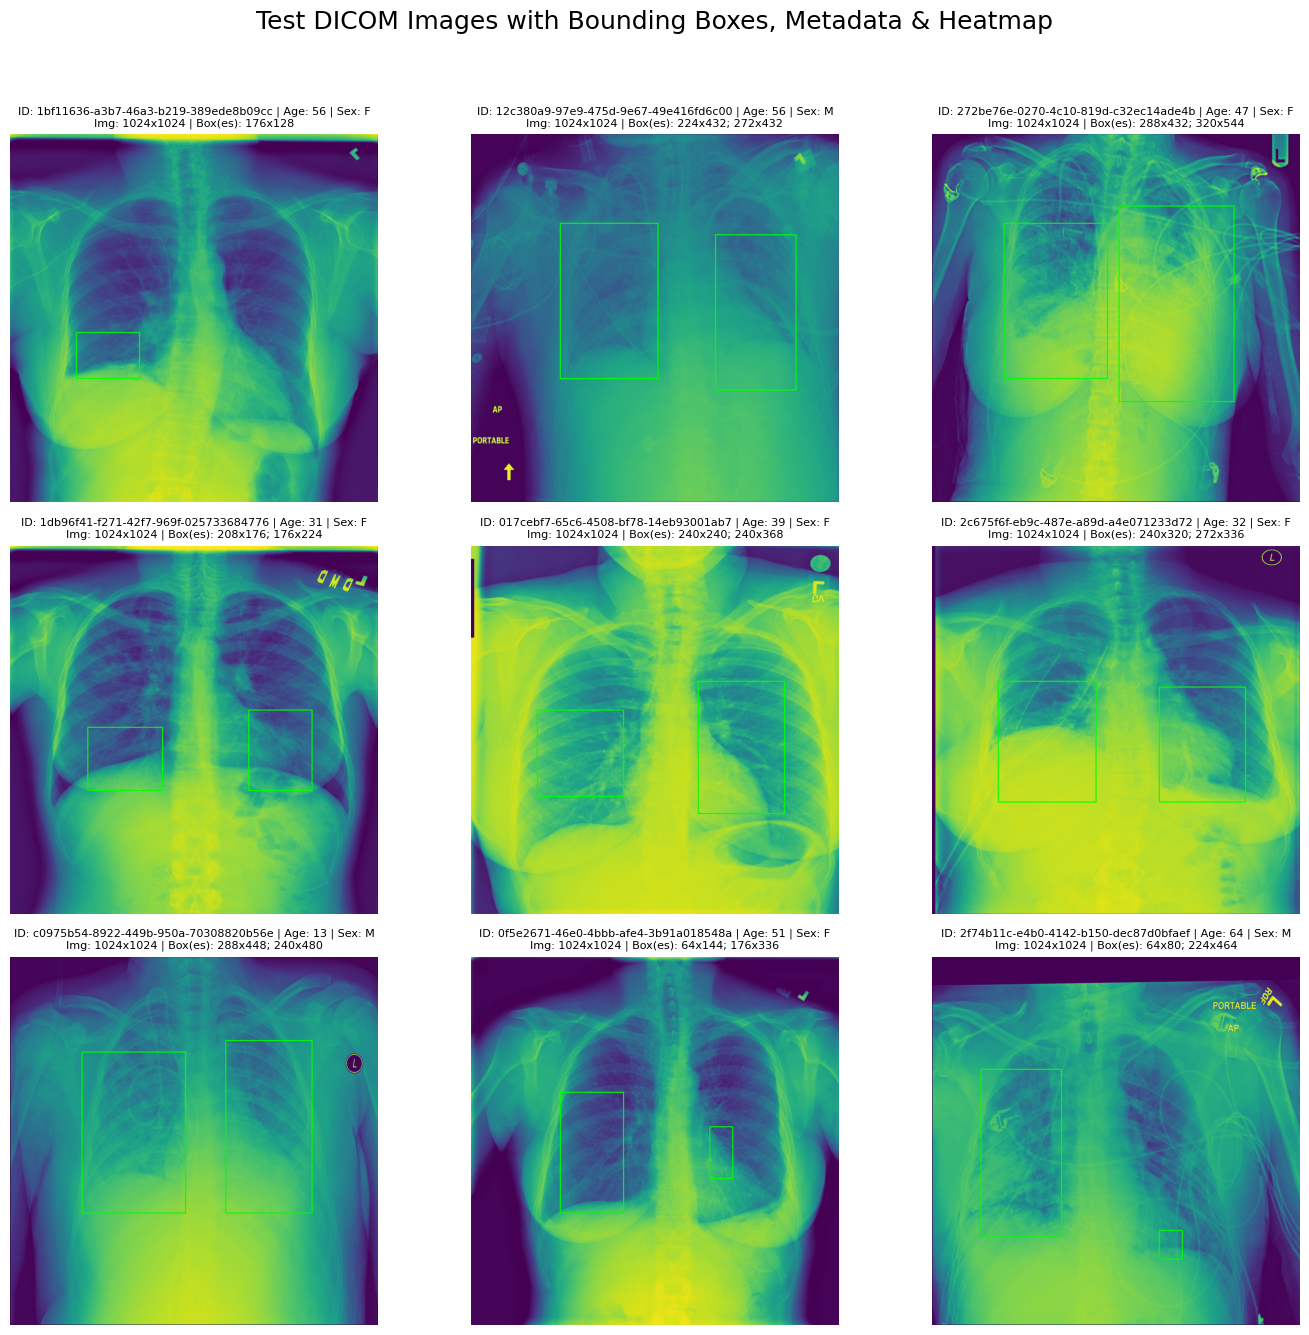

In [22]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
from tensorflow.keras.models import load_model

# --- Define DICOM path loader ---
def get_dicom_paths(directory):
    return [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith(".dcm")]

# --- Directories ---
TRAIN_IMG_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images"
TEST_IMG_DIR  = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_test_images"
MODEL_PATH    = r'C:\Users\samya\PyCharmProject\Pneumonia-Detection\xray_model.h5'

# --- Load U-Net model ---
model = load_model(MODEL_PATH)

# --- Load paths ---
train_img_paths = get_dicom_paths(TRAIN_IMG_DIR)
test_img_paths = get_dicom_paths(TEST_IMG_DIR)

# --- Function to process and visualize with heatmap, predictions, and metadata ---
def process_and_display_with_boxes(image_paths, title):
    fig, axes = plt.subplots(3, 3, figsize=(14, 14))
    fig.suptitle(title, fontsize=18)

    for ax, path in zip(axes.flatten(), image_paths):
        ds = pydicom.dcmread(path)
        image = ds.pixel_array.astype(np.float32)
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        original_size = image.shape

        # Resize and prepare for model
        input_image = cv2.resize(image, (64, 64))
        input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_GRAY2RGB)
        input_image_norm = input_image_rgb / 255.0
        input_image_norm = np.expand_dims(input_image_norm, axis=0)

        # Predict and threshold
        predicted_mask = model.predict(input_image_norm)[0, :, :, 0]
        binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255
        binary_mask_resized = cv2.resize(binary_mask, (original_size[1], original_size[0]))

        # Apply heatmap to original grayscale image
        heatmap_image = cv2.applyColorMap(image, cv2.COLORMAP_VIRIDIS)


        # Find contours and draw bounding boxes
        contours, _ = cv2.findContours(binary_mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        output_image = heatmap_image.copy()
        box_labels = []

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box
            box_labels.append(f"{w}x{h}")

        # --- Extract metadata ---
        patient_id = getattr(ds, "PatientID", "N/A")
        patient_age = getattr(ds, "PatientAge", "N/A")
        patient_sex = getattr(ds, "PatientSex", "N/A")
        dimensions = f"{original_size[0]}x{original_size[1]}"
        box_str = "; ".join(box_labels) if box_labels else "No box"

        # --- Show image ---
        ax.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title(
            f"ID: {patient_id} | Age: {patient_age} | Sex: {patient_sex}\n"
            f"Img: {dimensions} | Box(es): {box_str}",
            fontsize=8
        )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave room for suptitle
    plt.show()

# --- Randomly select 9 images from train and test ---
train_samples = random.sample(train_img_paths, 9)
test_samples = random.sample(test_img_paths, 9)

# --- Plot with heatmap, predictions, boxes, and metadata ---
process_and_display_with_boxes(train_samples, "Training DICOM Images with Bounding Boxes, Metadata & Heatmap")
process_and_display_with_boxes(test_samples, "Test DICOM Images with Bounding Boxes, Metadata & Heatmap")


In [28]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
from tensorflow.keras.models import load_model

# --- Define DICOM path loader ---
def get_dicom_paths(directory):
    return [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith(".dcm")]

# --- Directories ---
TRAIN_IMG_DIR = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_images"
TEST_IMG_DIR  = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_test_images"
MODEL_PATH    = r'C:\Users\samya\PyCharmProject\Pneumonia-Detection\xray_model.h5'

# --- Load U-Net model ---
model = load_model(MODEL_PATH)

# --- Load paths ---
train_img_paths = get_dicom_paths(TRAIN_IMG_DIR)
test_img_paths = get_dicom_paths(TEST_IMG_DIR)

# --- Function to process and visualize with heatmap, predictions, and metadata ---
def process_and_display_with_boxes(image_paths, title):
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    fig.suptitle(title, fontsize=18)

    for ax, path in zip(axes.flatten(), image_paths):
        ds = pydicom.dcmread(path)
        image = ds.pixel_array.astype(np.float32)
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        original_size = image.shape

        # Resize and prepare for model
        input_image = cv2.resize(image, (64, 64))
        input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_GRAY2RGB)
        input_image_norm = input_image_rgb / 255.0
        input_image_norm = np.expand_dims(input_image_norm, axis=0)

        # Predict and threshold
        predicted_mask = model.predict(input_image_norm)[0, :, :, 0]
        binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255
        binary_mask_resized = cv2.resize(binary_mask, (original_size[1], original_size[0]))

        # Apply VIRIDIS colormap to original grayscale image
        heatmap_image = cv2.applyColorMap(image, cv2.COLORMAP_VIRIDIS)

        # Find contours and draw red bounding boxes
        contours, _ = cv2.findContours(binary_mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        output_image = heatmap_image.copy()
        box_labels = []

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 0, 255), 2)  
            box_labels.append(f"{w}x{h}")

        # --- Extract metadata ---
        patient_id = getattr(ds, "PatientID", "N/A")
        patient_age = getattr(ds, "PatientAge", "N/A")
        patient_sex = getattr(ds, "PatientSex", "N/A")
        view_pos = getattr(ds, "ViewPosition", "N/A")
        dimensions = f"{original_size[0]}x{original_size[1]}"
        box_str = "; ".join(box_labels) if box_labels else "No box"

        # --- Show image ---
        ax.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title(
            f"ID: {patient_id} | Age: {patient_age} | Sex: {patient_sex} | View: {view_pos}\n"
            f"Size: {dimensions} | Box(es): {box_str}",
            fontsize=8
        )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave room for suptitle
    plt.show()

# --- Randomly select 9 images from train and test ---
train_samples = random.sample(train_img_paths, 9)
test_samples = random.sample(test_img_paths, 9)




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


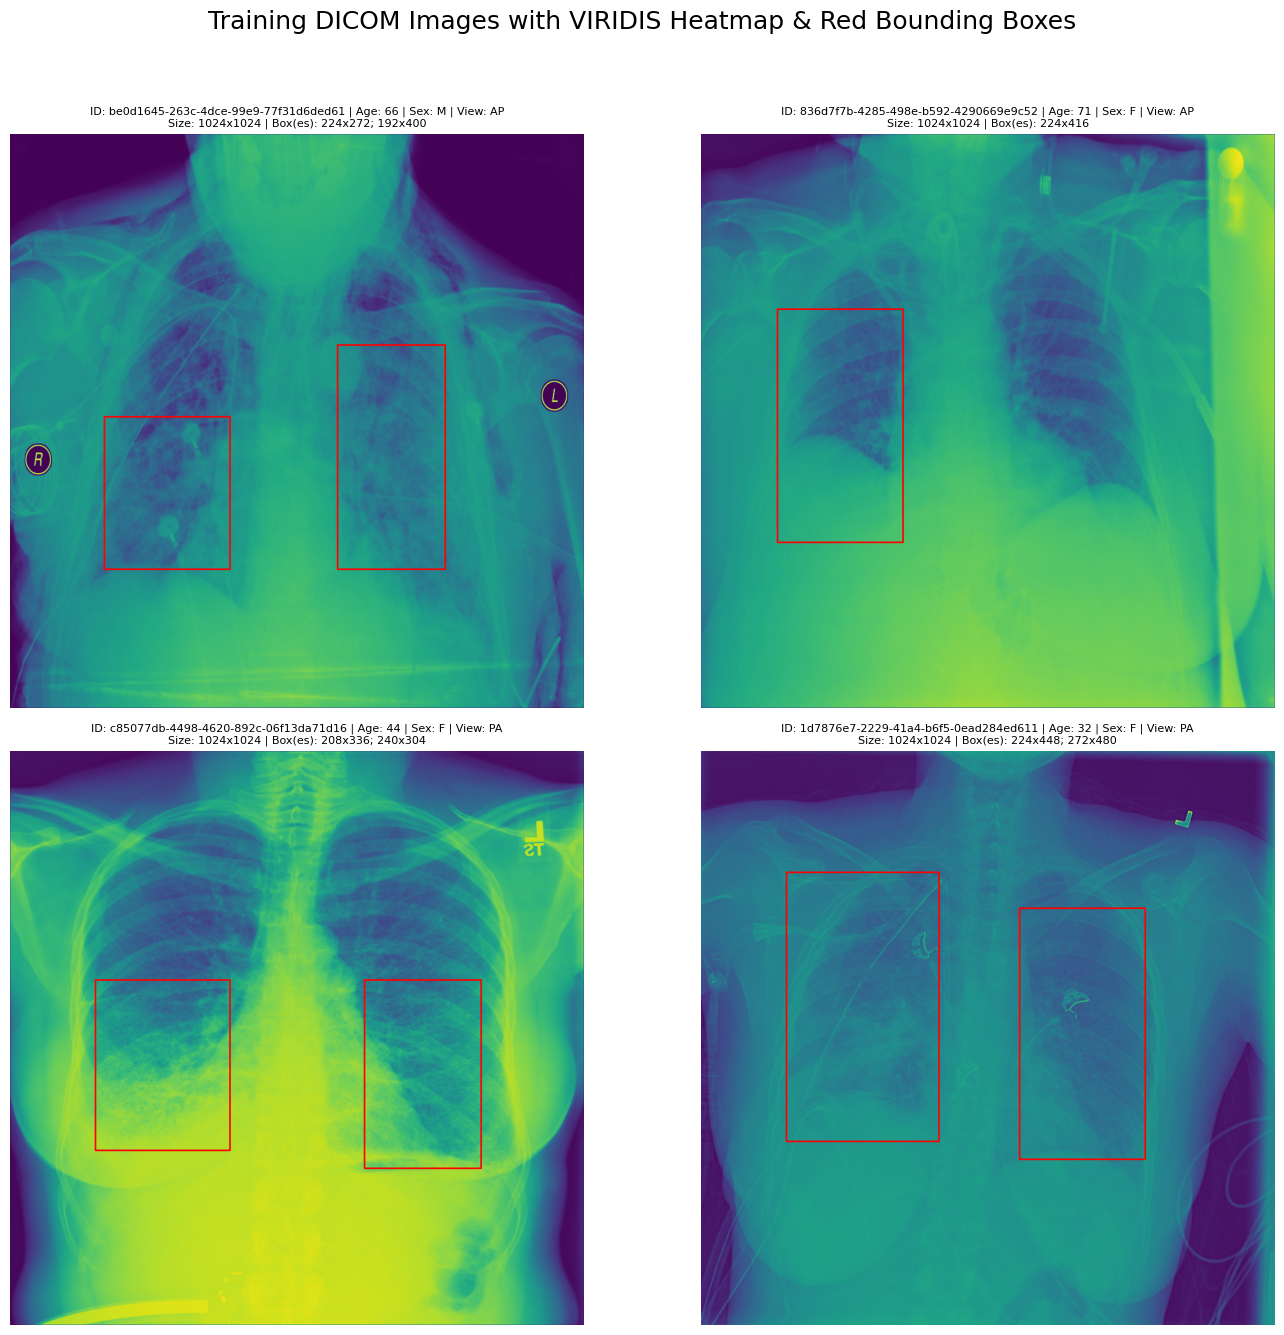

In [29]:
# --- Plot with heatmap, predictions, boxes, and metadata ---
process_and_display_with_boxes(train_samples, "Training DICOM Images with VIRIDIS Heatmap & Red Bounding Boxes")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


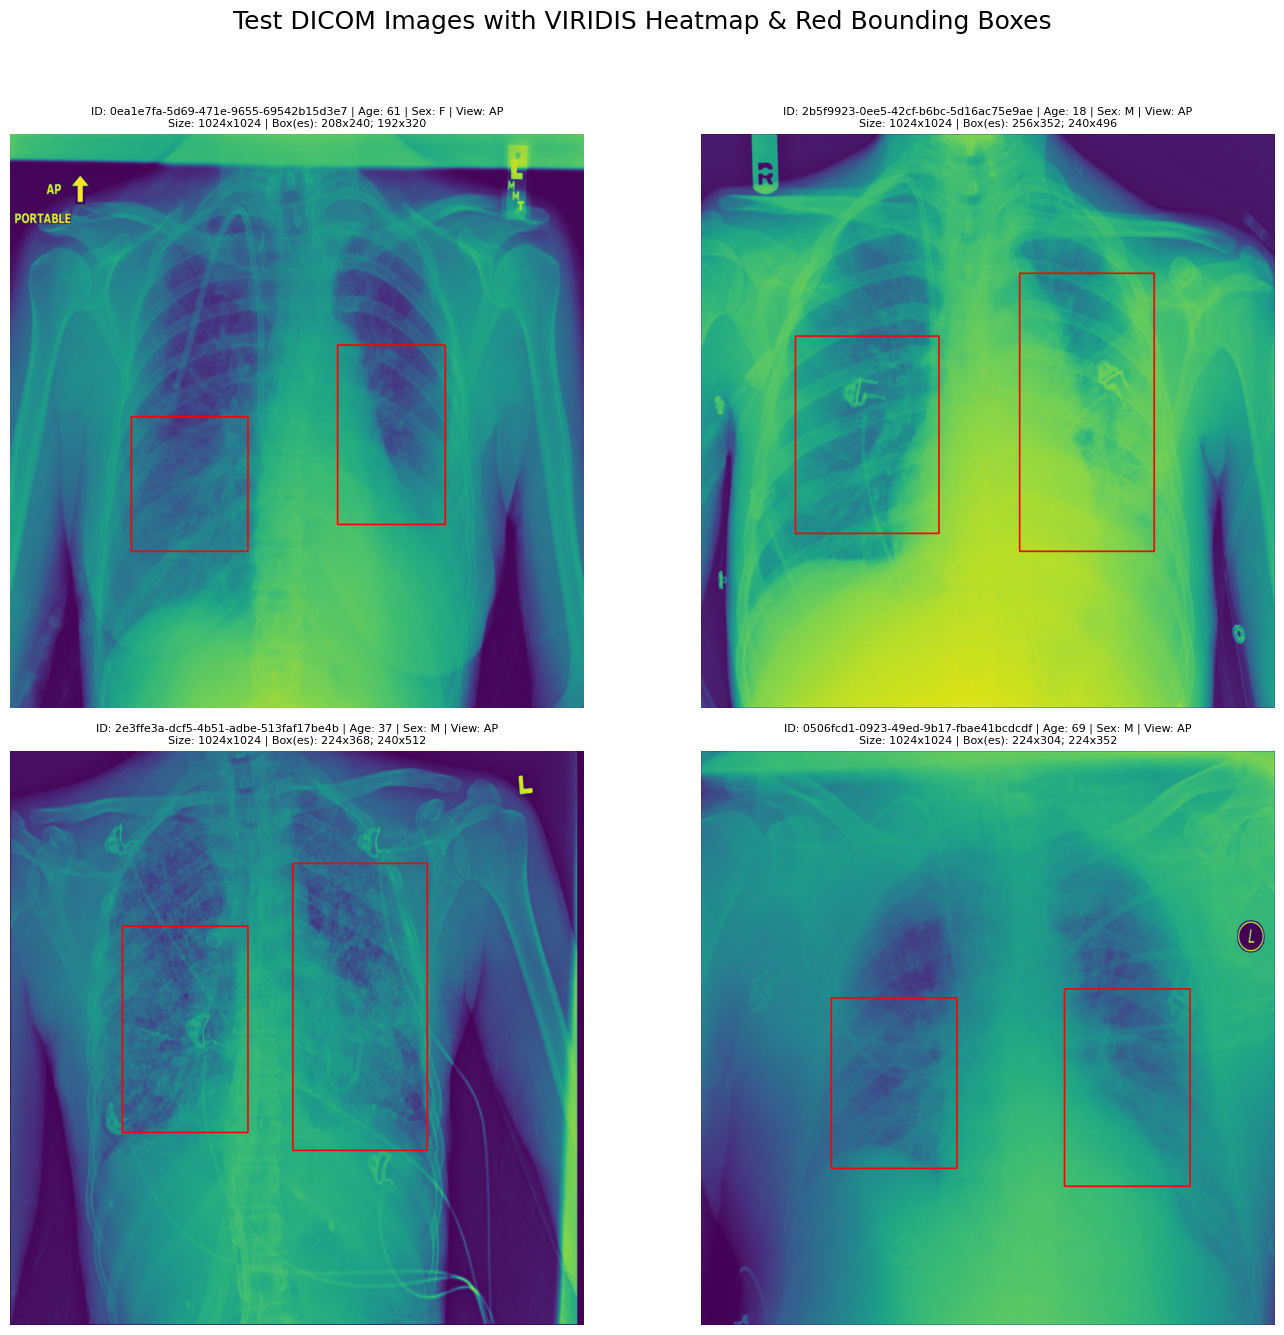

In [30]:
process_and_display_with_boxes(test_samples, "Test DICOM Images with VIRIDIS Heatmap & Red Bounding Boxes")

In [45]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw

# Parameters
image_size = (64, 64)
csv_path = r"C:\Users\samya\PyCharmProject\Pneumonia-Detection_dataset\data\stage_2_train_labels.csv"

# Load bounding box annotations
df = pd.read_csv(csv_path)
df = df[df['Target'] == 1]  # Only pneumonia cases
grouped = df.groupby('patientId')

# Generate binary masks
masks = {}
for patient_id, rows in grouped:
    mask = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for _, row in rows.iterrows():
        x, y, w, h = row['x'], row['y'], row['width'], row['height']
        scale_x = image_size[0] / 1024
        scale_y = image_size[1] / 1024
        x1 = int(x * scale_x)
        y1 = int(y * scale_y)
        x2 = int((x + w) * scale_x)
        y2 = int((y + h) * scale_y)
        draw.rectangle([x1, y1, x2, y2], fill=1)
    masks[patient_id] = np.array(mask)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


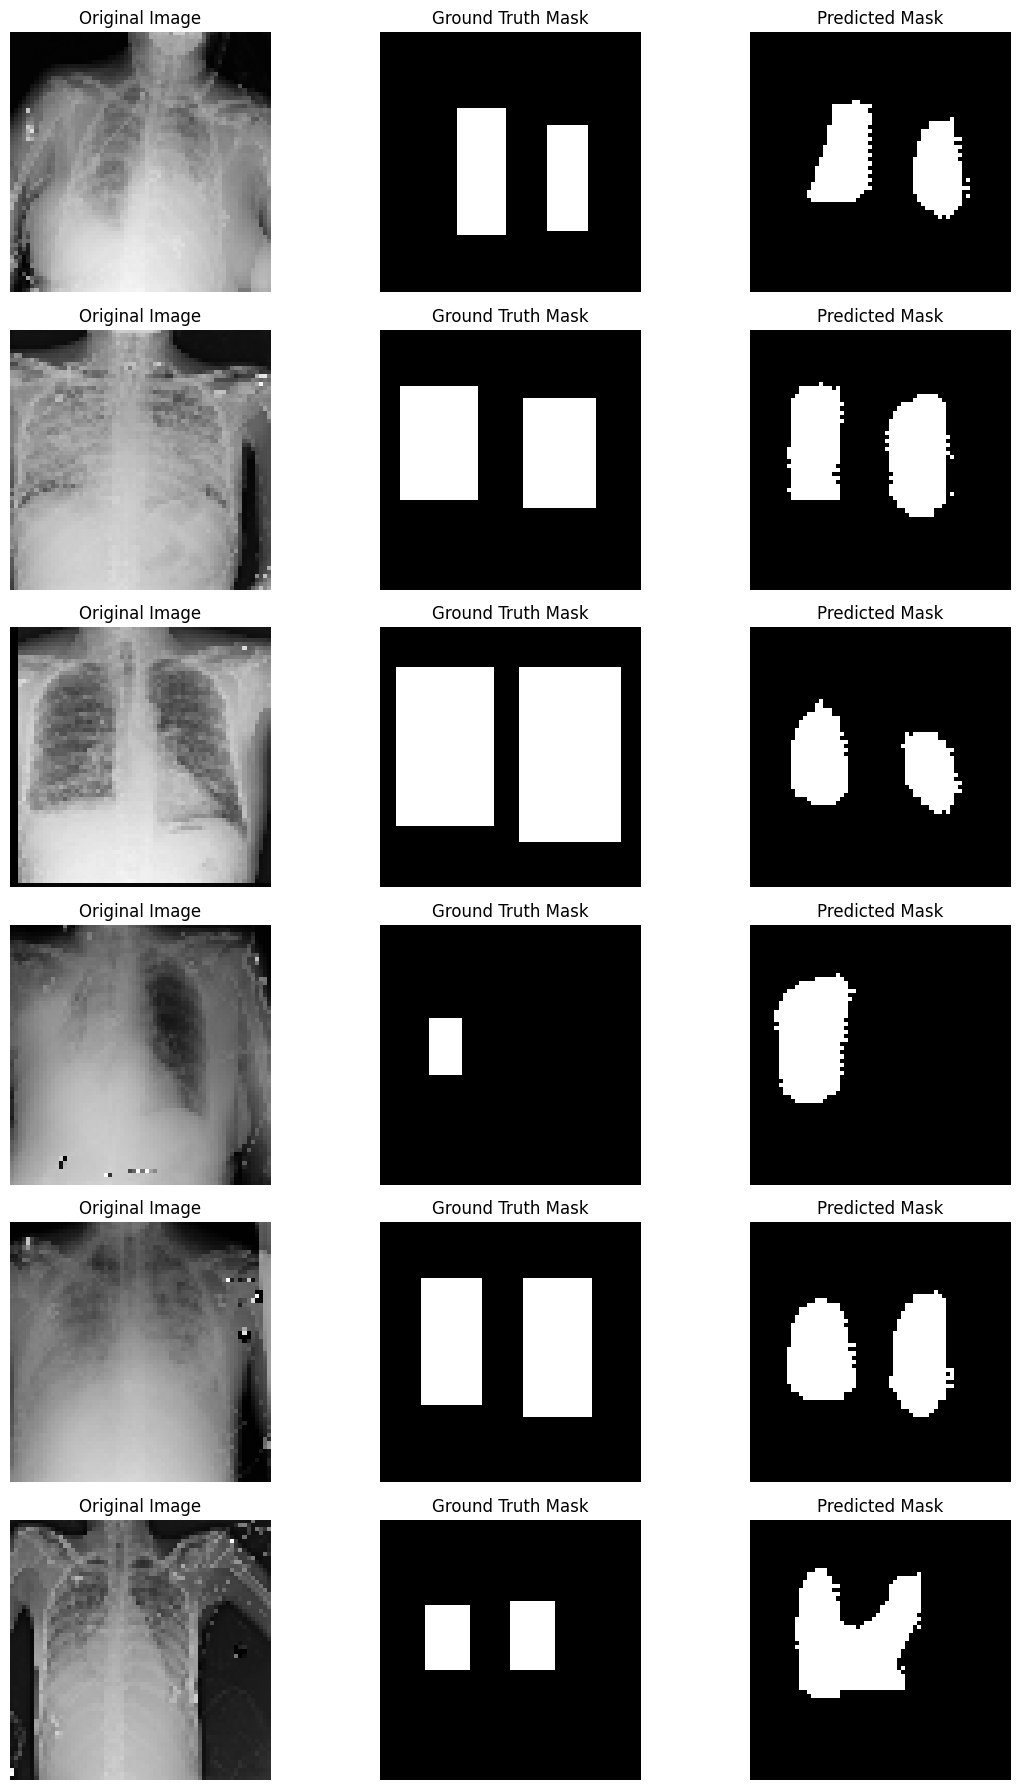

In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load model
model = load_model(r"C:\Users\samya\PyCharmProject\Pneumonia-Detection\xray_model.h5")

# Load image and mask data
image_dir = "npy_images"
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.npy')])
num_samples = 6

# Plot
fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))
for i in range(num_samples):
    fname = image_files[i]
    patient_id = os.path.splitext(fname)[0]

    # Load image
    image = np.load(os.path.join(image_dir, fname)) / 255.0
    input_image = np.expand_dims(image, axis=0)

    # Predict mask
    pred_mask = model.predict(input_image)[0, :, :, 0]
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

    # Load ground truth mask
    gt_mask = masks.get(patient_id, np.zeros((64, 64)))

    # Plot original image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')

    # Plot ground truth mask
    axes[i, 1].imshow(gt_mask, cmap='gray')
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis('off')

    # Plot predicted mask
    axes[i, 2].imshow(pred_mask_bin, cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()
